In [1]:
%cd ../..
%load_ext autoreload

%autoreload 2

/home/giacomowsl/Projects/sinergia/emplusvault


In [84]:
import os
import cv2
import sys
import timeit
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors 
from sklearn.cluster import DBSCAN, KMeans
from umap import UMAP

import openpifpaf
import faiss

from emv.features.pose import load_poses
from emv.features.pose_utils import draw_pose, KEYPOINTS_NAMES, ANGLES_ASSOCIATIONS

import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [4]:
local_poses_path = "data/pose_df.csv"
pose_df = load_poses(local_poses_path, n_sample=10000, merge_metadata=True)

Loading poses from local file...
Drop standing_still_angle poses
Drop sitting_pose_angle poses
Loaded 278242 poses.


In [6]:
pose_df.sport.value_counts()

sport
Archery           10000
Gymnastics        10000
Weightlifting     10000
Triathlon         10000
Tennis            10000
Taekwondo         10000
Table Tennis      10000
Swimming          10000
Skateboarding     10000
Shooting          10000
Sailing           10000
Rugby             10000
Athletics         10000
Judo              10000
Golf              10000
Football          10000
Fencing           10000
Equestrian        10000
Diving            10000
Cycling           10000
Canoeing          10000
Boxing            10000
Basketball        10000
Baseball          10000
Badminton         10000
Wrestling         10000
Surfing            7060
Rowing             6163
Sport Climbing     5019
Name: count, dtype: int64

# Get features

In [29]:
import requests
from emv.client.get_content import authenticate, API_BASE_URL

In [30]:
headers = authenticate()
feature_type = "pose"
page_size = 100
max_features = 100

response = requests.get(f"{API_BASE_URL}/features/{feature_type}", 
                        params = {
                            "page_size": page_size
                        }, 
                        headers=headers, 
                        verify=False)
results = response.json()

while len(results) < max_features:
    try:
        last_seen_feature_id = response.json()[-1]['feature_id']
    except:
        print(response.json())
        break
    response = requests.get(f"{API_BASE_URL}/features/{feature_type}", 
                            params = {
                                "page_size": page_size, 
                                "last_seen_feature_id": last_seen_feature_id
                            }, 
                            headers=headers, 
                            verify=False)
    new_results = response.json()
    if type(new_results) == dict and new_results.get("feature_id", None) is None:
        break
    results += new_results

print(f"Retrieved {len(results)} poses")

Authenticating...


/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/giacomowsl/.cache/pypoetry/virtualenvs/emv-o0uzL038-py3.10/lib/python3.10/site-packages/urllib3/connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host '10.179.68.6'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Retrieved 100 poses


In [78]:
results[0]

{'feature_id': 77574,
 'feature_type': 'pose',
 'version': '1',
 'created_at': '2023-10-27T12:31:04.886623',
 'model_name': 'PifPafModel.fast',
 'model_params': {'PifPafModel': 'fast'},
 'data': {'frames': [{'data': {'model_name': 'pifpaf_fast',
     'annotations': [{'bbox': [537.81, 238.3, 118.41, 200.36],
       'score': 0.758,
       'keypoints': [546.83,
        262.57,
        0.74,
        549.91,
        255.33,
        0.78,
        541.16,
        257.0,
        0.63,
        566.11,
        243.41,
        0.82,
        0.0,
        0.0,
        0.0,
        602.74,
        257.88,
        1.0,
        550.64,
        276.69,
        0.98,
        636.52,
        296.77,
        0.99,
        552.0,
        329.54,
        0.96,
        646.49,
        335.11,
        0.93,
        555.42,
        375.27,
        0.92,
        628.36,
        341.43,
        0.98,
        591.96,
        355.04,
        0.97,
        0.0,
        0.0,
        0.0,
        606.95,
        424.

# Pose search

In [49]:
features = pose_df.angle_vec.tolist()
features = np.array(features).astype('float32')
#faiss.normalize_L2(features) # normalize feature vectors to use inner product metric as cosine similarity
d = features.shape[1]

n_neighbors = 5

In [50]:
def eval_search(nearest_neighbors, n_iters = 5, n_neighbors = 5, show = False, **alg_params):
    times = []
    for i in range(n_iters):
        input_pose = pose_df.sample(1).iloc[0]
        start = timeit.default_timer()
        D, I = nearest_neighbors(input_pose, n_neighbors=n_neighbors, **alg_params)
        results = pose_df.iloc[I[0]].reset_index(drop=True)
        stop = timeit.default_timer()
        times.append(stop - start)

        if show:
            fig, axs = plt.subplots(nrows=1, ncols=n_neighbors + 1, figsize=((n_neighbors + 1) * 3, 3))
            axs = axs.flatten()
            draw_pose(input_pose, ax = axs[0], cut = True)
            axs[0].set_title("Input pose")
            for i, pose in results.iterrows():
                draw_pose(pose, ax = axs[i+1], cut = True)
            plt.show()

    print(f"Average time: {np.mean(times) * 1000} ms")
    print(f"Std time: {np.std(times) * 1000} ms")

## Baseline

In [17]:
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric = "cosine").fit(pose_df["angle_vec"].tolist())

def get_nearest_neighbors_base(input_pose, n_neighbors=5):
    input_pose = np.array(input_pose["angle_vec"]).astype('float32').reshape(1, -1)
    D, I = nbrs.kneighbors(input_pose)
    return D, I

In [18]:
eval_search(get_nearest_neighbors_base, n_iters = 100, n_neighbors = 5, show = False)

Average time: 3.8731070700123382 ms
Std time: 1.9264478439349866 ms


## FAISS

In [51]:
def get_nearest_neighbors_faiss(input_pose, faiss_index, n_neighbors=5):
    input_pose = np.array(input_pose["angle_vec"]).astype('float32').reshape(1,-1)
    #faiss.normalize_L2(input_pose)
    D, I = faiss_index.search(input_pose, n_neighbors)
    return D, I

### IndexFlatL2

In [52]:
index_flat = faiss.IndexFlatL2(d)
index_flat.add(features)

# Sanity check
D, I = index_flat.search(features[:5], 5)
print(I)
print(D)

[[    0 68250 44893 58729  3027]
 [    1   483 56755  8921 13120]
 [    2 27116 25685 31138 95874]
 [    3 33594 26827 61974 71439]
 [    4 55751 50680 35192 78588]]
[[0.0000000e+00 1.3646861e-02 1.4495098e-02 1.5478658e-02 1.6903641e-02]
 [0.0000000e+00 4.4165314e-03 5.8612959e-03 6.1438126e-03 7.2801560e-03]
 [0.0000000e+00 1.0258503e-02 1.2900140e-02 1.3446081e-02 1.7704947e-02]
 [0.0000000e+00 2.2974597e-05 1.4758336e-03 1.7360034e-03 1.9717528e-03]
 [0.0000000e+00 2.5033497e-04 4.1305626e-04 4.8605099e-04 4.9860228e-04]]


In [22]:
eval_search(get_nearest_neighbors_faiss, n_iters = 100, n_neighbors = 5, show = False, faiss_index = index_flat)

Average time: 0.498442049993173 ms
Std time: 0.14404205134891443 ms


### IndexIVFFlat

In [53]:
nlist = 50  # how many cells
quantizer = faiss.IndexFlatL2(d)
index_ivf = faiss.IndexIVFFlat(quantizer, d, nlist)

index_ivf.train(features)

index_ivf.add(features)

# Sanity check
D, I = index_ivf.search(features[:5], 5)
print(I)
print(D)

[[    0 68250 44893 58729  3027]
 [    1   483 56755  8921 13120]
 [    2 27116 25685 31138 95874]
 [    3 33594 26827 61974 71439]
 [    4 55751 50680 35192 78588]]
[[0.0000000e+00 1.3646861e-02 1.4495098e-02 1.5478658e-02 1.6903641e-02]
 [0.0000000e+00 4.4165314e-03 5.8612959e-03 6.1438126e-03 7.2801560e-03]
 [0.0000000e+00 1.0258503e-02 1.2900140e-02 1.3446081e-02 1.7704947e-02]
 [0.0000000e+00 2.2974597e-05 1.4758336e-03 1.7360034e-03 1.9717528e-03]
 [0.0000000e+00 2.5033497e-04 4.1305626e-04 4.8605099e-04 4.9860228e-04]]


In [24]:
index_ivf.nprobe = 5
eval_search(get_nearest_neighbors_faiss, n_iters = 100, n_neighbors = 5, show = False, faiss_index = index_ivf)

Average time: 0.1997495399609761 ms
Std time: 0.07133762347655298 ms


### IndexLSH

In [54]:
nbits = d*4  
index_lsh = faiss.IndexLSH(d, nbits)
index_lsh.add(features)

# Sanity check
D, I = index_lsh.search(features[:5], 5)
print(I)
print(D)

[[ 4169  7239 20247 21203     0]
 [    1   120   132   191    97]
 [  136     2  3756  4308  3508]
 [  343     3   650  1071   324]
 [   57    68    79   130     4]]
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [26]:
eval_search(get_nearest_neighbors_faiss, n_iters = 100, n_neighbors = 5, show = False, faiss_index = index_lsh)

Average time: 0.41758676999052113 ms
Std time: 0.10911877258818532 ms


# Accuracy evaluation

Compare the results between IndexFlatL2 (baseline) and other indexes.

In [67]:
def jaccard_similarity(pred_neighbors, true_neighbors):
    intersection = len(set(pred_neighbors) & set(true_neighbors))
    union = len(set(pred_neighbors) | set(true_neighbors))
    return intersection / union if union != 0 else 0

def compute_accuracy(predictions, references, threshold):
    total_correct = 0
    total_predictions = len(predictions)

    for pred_neighbors, true_neighbors in zip(predictions, references):
        similarity = jaccard_similarity(pred_neighbors, true_neighbors)
        # You can adjust the threshold based on your specific requirements
        if similarity > threshold:
            total_correct += 1

    accuracy = total_correct / total_predictions
    return accuracy

In [42]:
# Sample N pose from each sport as query
n_samples = 500
queries_per_sport = []
for sport in pose_df.sport.unique():
    queries_per_sport.append(pose_df[pose_df.sport == sport].sample(n_samples))

queries_per_sport = pd.concat(queries_per_sport)
queries_features = queries_per_sport.angle_vec.tolist()
queries_features = np.array(queries_features).astype('float32')
print(f"Sampled {len(queries_features)} poses")

Sampled 14500 poses


In [68]:
np.random.seed(1234)
accuracy_threshold = 0.9

features = pose_df[pose_df.index.isin(queries_per_sport.index) == False].angle_vec.tolist()
features = np.array(features).astype('float32')
print("N features:", len(features))
d = features.shape[1]

index_flat = faiss.IndexFlatL2(d)
index_flat.add(features)

time_start = timeit.default_timer()
dists_flat, refs = index_flat.search(queries_features, 5)
time_stop = timeit.default_timer()
print(f"Flat index time: {(time_stop - time_start) * 1000} ms")

N features: 263742
Flat index time: 5125.315139999657 ms


### IndexIVFFlat

In [69]:
results_ivf = []
quantizer = faiss.IndexFlatL2(d)

nlist_list = [10, 50, 100, 200, 500, 1000]
nprobe_list = [1, 5, 10, 20]

for nList in nlist_list:
    for nProbe in nprobe_list:
        index_ivf = faiss.IndexIVFFlat(quantizer, d, nList)
        index_ivf.train(features)
        index_ivf.add(features)
        index_ivf.nprobe = nProbe

        time_start = timeit.default_timer()
        dists_ivf, preds = index_ivf.search(queries_features, 5)
        time_end = timeit.default_timer()
        results_ivf.append({
            "nList": nList,
            "nProbe": nProbe,
            "accuracy": compute_accuracy(preds, refs, accuracy_threshold),
            "time_ms": (time_end - time_start) * 1000
        })

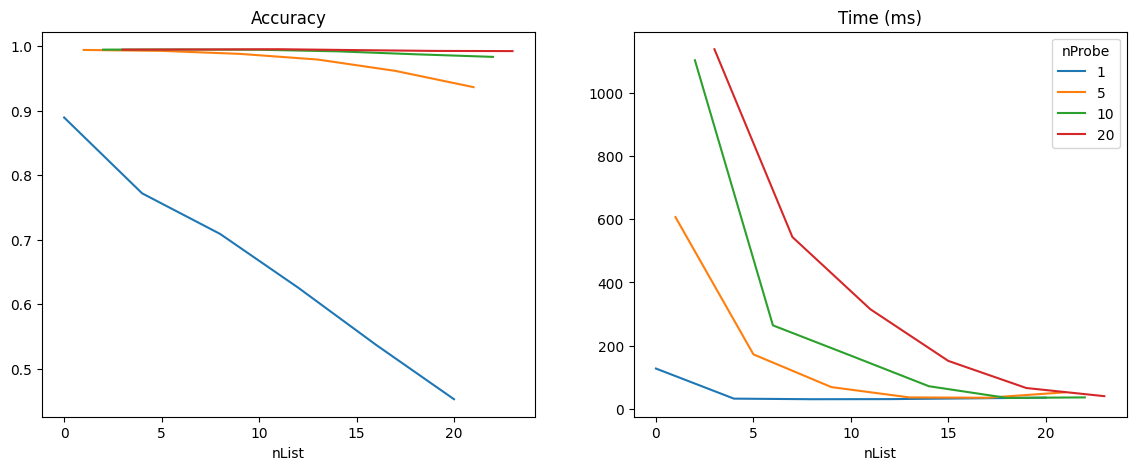

In [70]:
results_ivf = pd.DataFrame(results_ivf)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

for nprobe in nprobe_list:
    axs[0].plot(results_ivf[results_ivf.nProbe == nprobe].accuracy, label=f"{nprobe}")
    axs[1].plot(results_ivf[results_ivf.nProbe == nprobe].time_ms, label=f"{nprobe}")
    axs[0].set_title("Accuracy")
    axs[1].set_title("Time (ms)")
    axs[0].set_xlabel("nList")
    axs[1].set_xlabel("nList")

plt.legend(title = "nProbe")
plt.show()

In [71]:
results_ivf[results_ivf.accuracy > 0.99]

,nList,nProbe,accuracy,time_ms
1,10,5,0.993931,606.709883
2,10,10,0.994414,1102.995883
3,10,20,0.994414,1138.092542
5,50,5,0.992483,172.205939
6,50,10,0.994621,264.019651
7,50,20,0.994621,543.583599
10,100,10,0.994207,168.120190
11,100,20,0.995034,314.960500
14,200,10,0.991793,71.353851
15,200,20,0.993655,151.422851


### IndexLSH

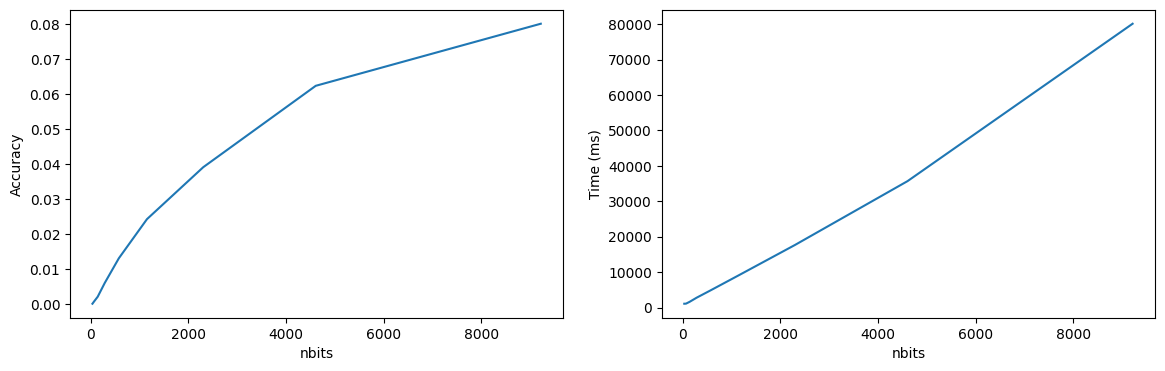

In [72]:
results_lsh = []

for res in [4, 8, 16, 32, 64, 128, 256, 512, 1024]:
    nbits = d*res
    index_lsh = faiss.IndexLSH(d, nbits)
    index_lsh.add(features)

    time_start = timeit.default_timer()
    dists_lsh, preds = index_lsh.search(queries_features, 5)
    time_end = timeit.default_timer()
    results_lsh.append({
        "nbits": nbits,
        "accuracy": compute_accuracy(preds, refs, accuracy_threshold),
        "time_ms": (time_end - time_start) * 1000
    })

results_lsh = pd.DataFrame(results_lsh)
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
axs[0].plot(results_lsh.groupby("nbits").accuracy.mean())
axs[0].set_ylabel("Accuracy")
axs[0].set_xlabel("nbits")

axs[1].plot(results_lsh.groupby("nbits").time_ms.mean())
axs[1].set_ylabel("Time (ms)")
axs[1].set_xlabel("nbits")

plt.show()

In [73]:
results_lsh[results_lsh.accuracy > accuracy_threshold]

,nbits,accuracy,time_ms


### IndexHNSWFlat

In [74]:
results_hnsw = []

m_values = [4, 8, 16, 32, 64, 128]
ef_search_values = [8, 16, 32, 64, 128]
ef_construction_values = [8, 16, 32, 64]

for M in m_values:
    for ef_search in ef_search_values:
        for ef_construction in ef_construction_values:
            index_hnsw = faiss.IndexHNSWFlat(d, M)
            index_hnsw.hnsw.efSearch = ef_search
            index_hnsw.hnsw.efConstruction = ef_construction
            index_hnsw.add(features)

            time_start = timeit.default_timer()
            dists_hnsw, preds = index_hnsw.search(queries_features, 5)
            time_end = timeit.default_timer()
            results_hnsw.append({
                "M": M,
                "efSearch": ef_search,
                "efConstruction": ef_construction,
                "accuracy": compute_accuracy(preds, refs, accuracy_threshold),
                "time_ms": (time_end - time_start) * 1000
            })

results_hnsw = pd.DataFrame(results_hnsw)

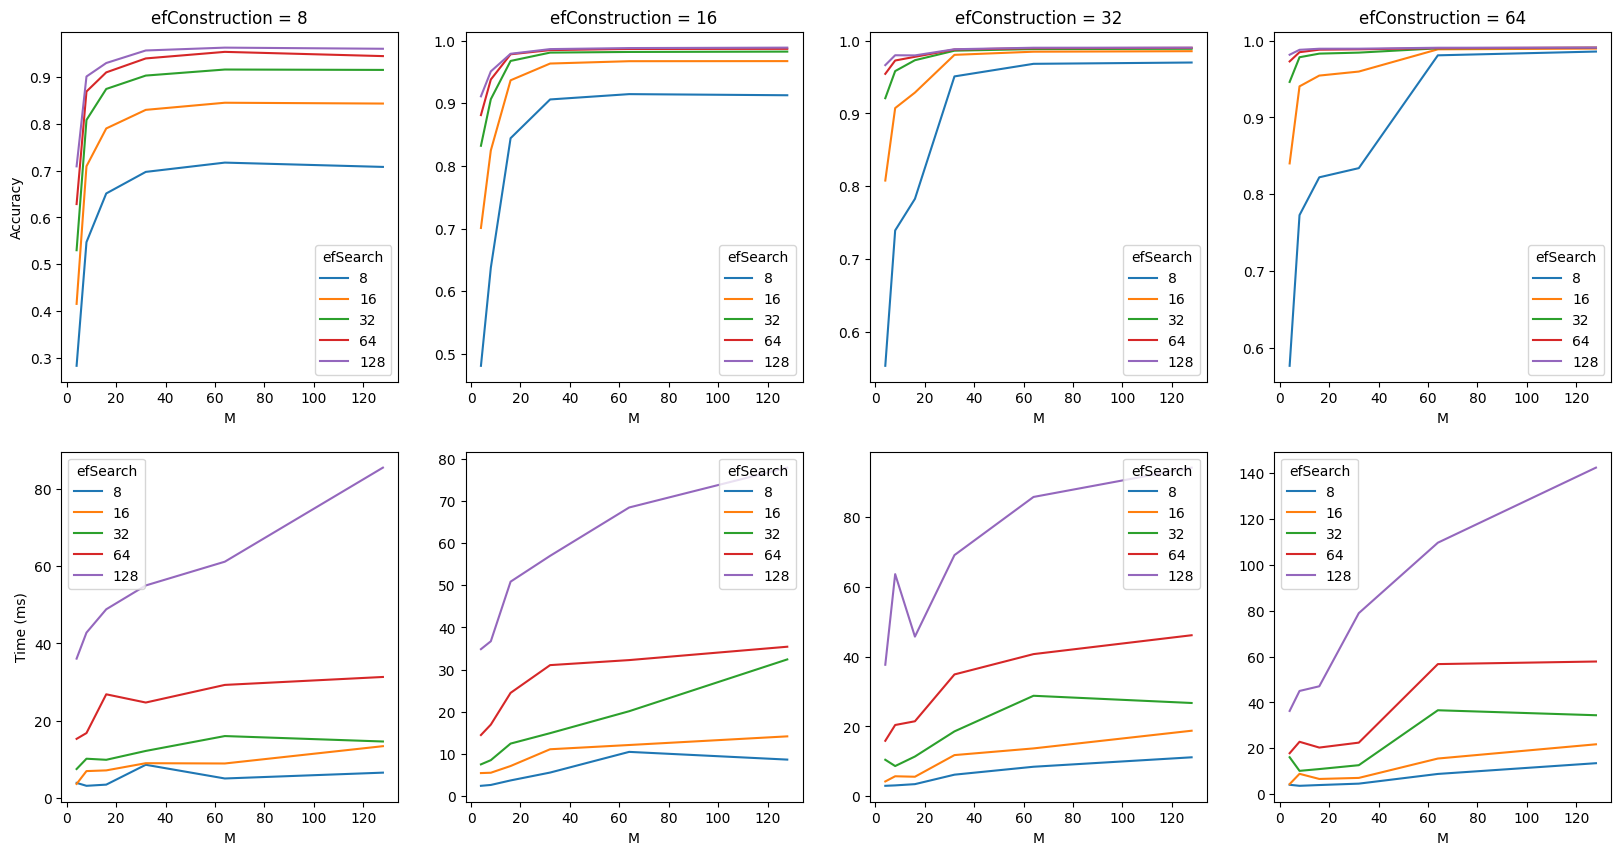

In [75]:
fig, axs = plt.subplots(nrows=2, ncols=len(ef_construction_values), figsize=(20, 10))

for i, ef_construction in enumerate(ef_construction_values):
    results_at_ef_rec = results_hnsw[results_hnsw.efConstruction == ef_construction]
    for ef_search in ef_search_values:
        results_at_ef = results_at_ef_rec[results_at_ef_rec.efSearch == ef_search]
        axs[0,i].plot(results_at_ef.M, results_at_ef.accuracy, label=str(ef_search))
        axs[1,i].plot(results_at_ef.M, results_at_ef.time_ms, label=str(ef_search))
    axs[0,i].set_title(f"efConstruction = {ef_construction}")
    axs[0,i].legend(title = "efSearch")
    axs[1,i].legend(title = "efSearch")
    axs[0,i].set_xlabel("M")
    axs[1,i].set_xlabel("M")
axs[0,0].set_ylabel("Accuracy")
axs[1,0].set_ylabel("Time (ms)")
plt.show()

In [76]:
results_hnsw[results_hnsw.accuracy > accuracy_threshold].sort_values(["accuracy", "time_ms"], ascending=False)[:5]

,M,efSearch,efConstruction,accuracy,time_ms
119,128,128,64,0.990759,142.463889
115,128,64,64,0.990759,57.840287
99,64,128,64,0.990621,109.700288
118,128,128,32,0.990621,94.128484
98,64,128,32,0.990483,85.731431


# Results per sport

In [77]:
M = 128
ef_search = 64
ef_construction = 64

index_hnsw = faiss.IndexHNSWFlat(d, M)
index_hnsw.hnsw.efSearch = ef_search
index_hnsw.hnsw.efConstruction = ef_construction
index_hnsw.add(features)

time_start = timeit.default_timer()
dists_hnsw, preds = index_hnsw.search(queries_features, 5)
time_end = timeit.default_timer()
print('Time: {:.2f} s'.format(time_end - time_start))

accuracy = compute_accuracy(preds, refs, threshold=0.9)
print('Accuracy: {:.4f}'.format(accuracy))


Time: 0.06 s
Accuracy: 0.9910


In [78]:
queries_per_sport["preds"] = preds.tolist() 
queries_per_sport["refs"] = refs.tolist()

results_per_sport = []
for sport in queries_per_sport.sport.unique():
    sport_queries = queries_per_sport[queries_per_sport.sport == sport]
    accuracy = compute_accuracy(sport_queries.preds.tolist(), sport_queries.refs.tolist(), threshold=0.9)
    results_per_sport.append({
        "sport": sport,
        "accuracy": accuracy
    })

results_per_sport = pd.DataFrame(results_per_sport)

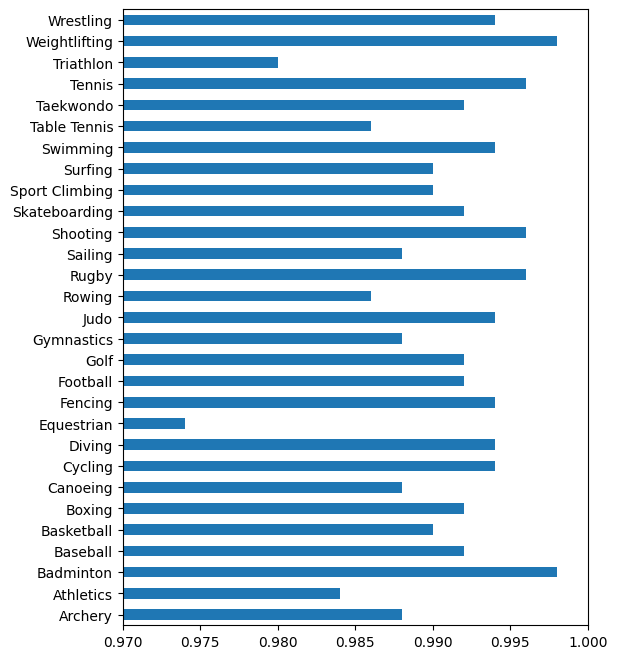

In [64]:
fig, ax = plt.subplots(figsize=(6, 8))
results_per_sport.plot(kind = "barh", ax = ax)
ax.set_yticks(range(len(results_per_sport)), results_per_sport.sport)
ax.set_xlim([0.97, 1])
plt.legend("").remove()
plt.show()

### Visualize results

In [ ]:
n_sample = 3
n_neighbors = 5
for sport in queries_per_sport.sport.unique():
    sport_queries = queries_per_sport[queries_per_sport.sport == sport].sample(n_sample).reset_index(drop=True)
    fig, axs = plt.subplots(nrows=n_sample, ncols=n_neighbors + 1, figsize=((n_neighbors + 1) * 2, n_sample * 2))
    for i in range(n_sample):
        draw_pose(sport_queries.iloc[i], ax = axs[i,0], cut = True)
        axs[i,0].set_title("Input pose")
        for j in range(n_neighbors):
            draw_pose(pose_df.iloc[sport_queries.preds[i][j]], ax = axs[i,j + 1], cut = True)
    plt.suptitle(sport)
    plt.tight_layout()
    plt.show()

### Check distances

In [93]:
M = 128
ef_search = 64
ef_construction = 64

index_hnsw = faiss.IndexHNSWFlat(d, M)
index_hnsw.hnsw.efSearch = ef_search
index_hnsw.hnsw.efConstruction = ef_construction
index_hnsw.add(features)

time_start = timeit.default_timer()
dists_hnsw, preds = index_hnsw.search(queries_features, 100)
time_end = timeit.default_timer()

In [94]:
dists_hnsw.shape

(14500, 100)

In [101]:
dists_hnsw

array([[0.00197154, 0.00233   , 0.00241162, ..., 0.00754501, 0.0076095 ,
        0.00768579],
       [0.0055399 , 0.01050391, 0.01497992, ..., 0.04979369, 0.05006174,
        0.0501152 ],
       [0.0078794 , 0.0078794 , 0.00903027, ..., 0.05502458, 0.05503848,
        0.05505388],
       ...,
       [0.00148108, 0.00151213, 0.00152456, ..., 0.04058161, 0.04066055,
        0.04074339],
       [0.01693678, 0.02887354, 0.0353224 , ..., 0.08238989, 0.08246024,
        0.0825864 ],
       [0.00129725, 0.00140853, 0.0030104 , ..., 0.01032177, 0.01039382,
        0.01039949]], dtype=float32)

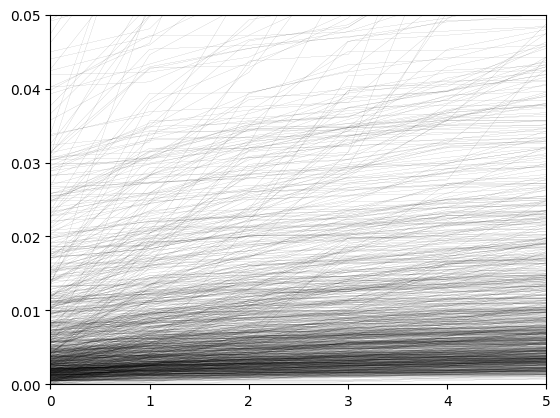

In [120]:
for dist in dists_hnsw[:1000]:
    plt.plot(dist, color = "black", linewidth = 0.05)
plt.ylim([0, 0.05])
plt.xlim([0,5])
plt.show()